# Install packages

In [1]:
%%writefile requirements.txt
transformers==4.55.0
matplotlib==3.10.5
accelerate==1.10.0
datasets==4.0.0
nlpaug==1.1.11
tensorflow==2.20.0rc0
torch==2.8.0
torchvision==0.23.0
pyngrok==7.3.0
uvicorn==0.35.0
fastapi==0.116.1
bitsandbytes

Writing requirements.txt


In [2]:
!pip install -qr requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 88.5 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 98.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 38.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 5.0 MB/

# Importing Libraries


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
# import transformers
import tensorflow as tf
import re
import nltk
import random

from tqdm import tqdm
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.layers import Input, BatchNormalization, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
# from tensorflow.keras.callbacks import EarlyStopping

from transformers import BitsAndBytesConfig, pipeline, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from huggingface_hub import notebook_login

from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict, load_dataset
from collections import Counter
from torch.utils.data import DataLoader

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet


random.seed(42)
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next r

True

# Reading Dataset

In [4]:
dataset = pd.read_csv("/kaggle/input/toxic-data/cellula toxic data.csv")
dataset.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [5]:
pd.unique(dataset.iloc[:, -1])

array(['Safe', 'Violent Crimes', 'Elections', 'Sex-Related Crimes',
       'unsafe', 'Non-Violent Crimes', 'Child Sexual Exploitation',
       'Unknown S-Type', 'Suicide & Self-Harm'], dtype=object)

# Talk with Dataset

In [6]:
dataset.loc[~dataset['Toxic Category'].isin(['Safe', 'Elections']), 'Toxic Category'] = 'Unsafe'
dataset.loc[dataset['Toxic Category'].isin(['Elections']), 'Toxic Category'] = 'Safe'

dataset

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Unsafe
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Safe
...,...,...,...
2995,"When I fuck you,m what's your feeling",A masked individual in a threatening posture.,Unsafe
2996,"In a baking contest, another participant won a...",A family enjoying a picnic in the park.,Safe
2997,How do I navigate a specific real estate trans...,People walking through a peaceful city street.,Safe
2998,"At a bowling alley, someone was hogging the la...",People walking through a peaceful city street.,Safe


In [7]:
# what is your labels?
pd.unique(dataset.iloc[:, -1])

array(['Safe', 'Unsafe'], dtype=object)

In [8]:
# what about balance?
dataset.iloc[:, -1].value_counts()

Toxic Category
Unsafe    1895
Safe      1105
Name: count, dtype: int64

In [9]:
print(dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True, ignore_index= True)
print(dataset.duplicated().sum())

973
0


In [10]:
dataset.iloc[:, -1].value_counts()

Toxic Category
Unsafe    1142
Safe       885
Name: count, dtype: int64

# Preprocessing

In [11]:
dataset["merged_text"] = dataset["query"] + " " + dataset["image descriptions"]
dataset.head()

,query,image descriptions,Toxic Category,merged_text
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe,What is the right way to handle a severe head ...
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe,What's the best way to keep criminal elements ...
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe,Tell me if my chronic headache is a sign of a ...
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Unsafe,Suggest the best real estate investments in my...
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Safe,What are the health benefits of daily exercise...


In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(dataset["merged_text"], dataset["Toxic Category"], stratify= dataset["Toxic Category"], test_size=0.5, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, stratify= y_temp, test_size=0.5, random_state=42)

In [13]:
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Synonym Augmentation

In [14]:
def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random.shuffle(words)
    num_replaced = 0

    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym_words = [lemma.name().replace("_", " ") for s in synonyms for lemma in s.lemmas() if lemma.name() != word]
            synonym_words = list(set(synonym_words))
            if synonym_words:
                new_word = random.choice(synonym_words)
                index = new_words.index(word)
                new_words[index] = new_word
                num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

In [15]:
train_augmented_rows = []


for i in range(50):
    for _, row in train_df.iterrows():
        original_query = row['merged_text']
        augmented_query = synonym_replacement(original_query, n=2)

        new_row = row.copy()
        new_row['merged_text'] = augmented_query
        train_augmented_rows.append(new_row)
df_augmented_train = pd.DataFrame(train_augmented_rows)
train_df = pd.concat([train_df, df_augmented_train]).reset_index(drop=True)

In [16]:
# Deal with duplicates
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True, ignore_index= True)
print(train_df.duplicated().sum())

666
0


In [17]:
# what about balance?
train_df.iloc[:, -1].value_counts()

Toxic Category
Unsafe    28753
Safe      22244
Name: count, dtype: int64

In [18]:
test_df.iloc[:,-1].value_counts()

Toxic Category
Unsafe    285
Safe      222
Name: count, dtype: int64

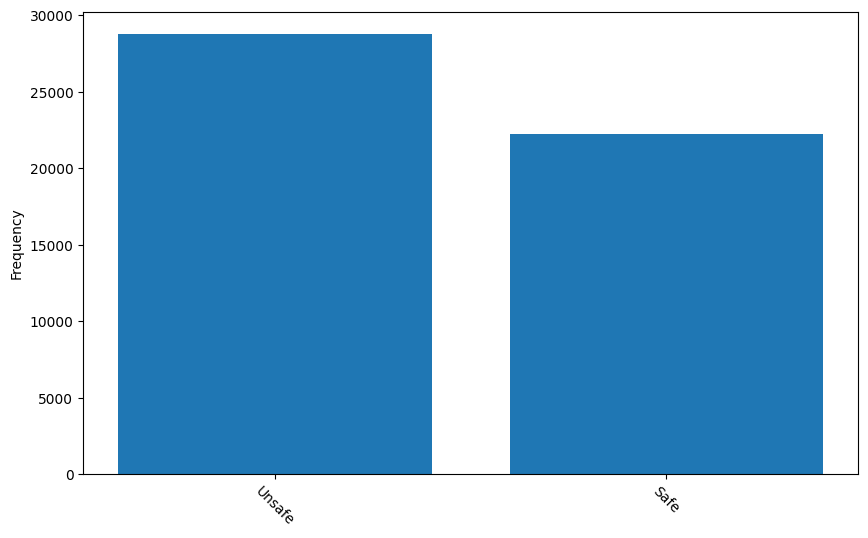

In [19]:
# Some Visualization

plt.figure(figsize=(10,6))
plt.bar(train_df.iloc[:, -1].value_counts().index, train_df.iloc[:, -1].value_counts().values)
plt.xticks(rotation=-45)
plt.ylabel("Frequency")
plt.show()

# PreProcessing

In [20]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)


train_df["text_cleaned"] = train_df["merged_text"].apply(clean_text)
valid_df["text_cleaned"] = valid_df["merged_text"].apply(clean_text)
test_df["text_cleaned"] = test_df["merged_text"].apply(clean_text)

train_df["text_cleaned"].head()

0    true great artists cant teach family enjoying ...
1    hack bank account emergency vehicle flashing l...
2    asians ever done weakest race opinion emergenc...
3    really love latinas always nice curves nice ro...
4    got hands couple ounces weed illegal think bes...
Name: text_cleaned, dtype: object

In [21]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(token) for token in tokens])

train_df["lemma_text"] = train_df["text_cleaned"].apply(lemmatize_text)
valid_df["lemma_text"] = valid_df["text_cleaned"].apply(lemmatize_text)
test_df["lemma_text"] = test_df["text_cleaned"].apply(lemmatize_text)

train_df["lemma_text"].head()

0    true great artist cant teach family enjoying p...
1    hack bank account emergency vehicle flashing l...
2    asian ever done weakest race opinion emergency...
3    really love latinas always nice curve nice rou...
4    got hand couple ounce weed illegal think best ...
Name: lemma_text, dtype: object

In [23]:
label_map = {
    'Safe': 0,
    'Unsafe': 1
}

In [24]:
train_df['Toxic Category'] = train_df['Toxic Category'].map(label_map)
valid_df['Toxic Category'] = valid_df['Toxic Category'].map(label_map)
test_df['Toxic Category'] = test_df['Toxic Category'].map(label_map)

In [25]:
train_dataset_un = Dataset.from_pandas(train_df)
valid_dataset_un = Dataset.from_pandas(valid_df)
test_dataset_un = Dataset.from_pandas(test_df)

In [26]:
dataset_dict_un = DatasetDict({
    "train": train_dataset_un,
    "valid": valid_dataset_un,
    "test": test_dataset_un
})

In [27]:
dataset_dict_un

DatasetDict({
    train: Dataset({
        features: ['merged_text', 'Toxic Category', 'text_cleaned', 'lemma_text'],
        num_rows: 50997
    })
    valid: Dataset({
        features: ['merged_text', 'Toxic Category', 'text_cleaned', 'lemma_text', '__index_level_0__'],
        num_rows: 507
    })
    test: Dataset({
        features: ['merged_text', 'Toxic Category', 'text_cleaned', 'lemma_text', '__index_level_0__'],
        num_rows: 507
    })
})

In [28]:
dataset_dict_un = dataset_dict_un.rename_columns({
    "lemma_text": "text",
    "Toxic Category": "label"
})
# dataset_dict_un = dataset_dict_un.remove_columns("__index_level_0__")
dataset_dict_un

DatasetDict({
    train: Dataset({
        features: ['merged_text', 'label', 'text_cleaned', 'text'],
        num_rows: 50997
    })
    valid: Dataset({
        features: ['merged_text', 'label', 'text_cleaned', 'text', '__index_level_0__'],
        num_rows: 507
    })
    test: Dataset({
        features: ['merged_text', 'label', 'text_cleaned', 'text', '__index_level_0__'],
        num_rows: 507
    })
})

### Tockenization

In [30]:
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True
)

In [31]:
model_ckpt = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [32]:
def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Apply to whole DatasetDict
tokenized_dataset = dataset_dict_un.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
print(tokenized_dataset)

Map:   0%|          | 0/50997 [00:00<?, ? examples/s]

Map:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/507 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['merged_text', 'label', 'text_cleaned', 'text', 'input_ids', 'attention_mask'],
        num_rows: 50997
    })
    valid: Dataset({
        features: ['merged_text', 'label', 'text_cleaned', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 507
    })
    test: Dataset({
        features: ['merged_text', 'label', 'text_cleaned', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 507
    })
})


# Model

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "distilbert/distilbert-base-uncased"
llm_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-Tuninig

In [34]:
peft_config = LoraConfig(
    task_type = "SEQ_CLS",
    r= 8,
    lora_alpha = 16,
    lora_dropout=0.2,
    target_modules=['q_lin', "v_lin"]
)

In [35]:
llm_model = get_peft_model(llm_model, peft_config)
llm_model.print_trainable_parameters()

trainable params: 744,969 || all params: 67,705,362 || trainable%: 1.1003


In [36]:
from sklearn.metrics import f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_macro = f1_score(labels, predictions, average="macro")
    return {"f1_macro": f1_macro}

In [37]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps",
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Select best model based on F1 Macro
    greater_is_better=False                 # Higher F1 is better
)

In [40]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch

# Get label values from the Hugging Face dataset
y_train = np.array(tokenized_dataset["train"]["label"])

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights


tensor([1.1463, 0.8868])

In [41]:
import torch
import torch.nn as nn
from transformers import Trainer

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Tensor of shape [num_classes] or scalar
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)  # pt = softmax probability of correct class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [42]:
class FocalTrainer(Trainer):
    def __init__(self, *args, class_weights=None, gamma=2, **kwargs):
        self.class_weights = torch.tensor(class_weights) if class_weights is not None else None
        self.gamma = gamma
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = logits.device
        weight = self.class_weights.to(device) if self.class_weights is not None else None

        loss_fn = FocalLoss(alpha=weight, gamma=self.gamma)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [43]:
from transformers import Trainer

trainer = FocalTrainer(
    model=llm_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    gamma=2.0
)
trainer.train()

/tmp/ipykernel_36/2672943071.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Macro
500,0.070500,0.049434,0.952140
1000,0.014100,0.066473,0.948014
1500,0.007100,0.079057,0.966166


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1594, training_loss=0.029087679374173114, metrics={'train_runtime': 461.733, 'train_samples_per_second': 220.894, 'train_steps_per_second': 3.452, 'total_flos': 3436496081280000.0, 'train_loss': 0.029087679374173114, 'epoch': 2.0})

## Evaluation

In [44]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.049434367567300797,
 'eval_f1_macro': 0.9521397105097547,
 'eval_runtime': 1.0836,
 'eval_samples_per_second': 467.891,
 'eval_steps_per_second': 7.383,
 'epoch': 2.0}

In [45]:
predictions = trainer.predict(tokenized_dataset["test"])
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       222
           1       0.98      0.94      0.96       285

    accuracy                           0.95       507
   macro avg       0.95      0.96      0.95       507
weighted avg       0.96      0.95      0.95       507



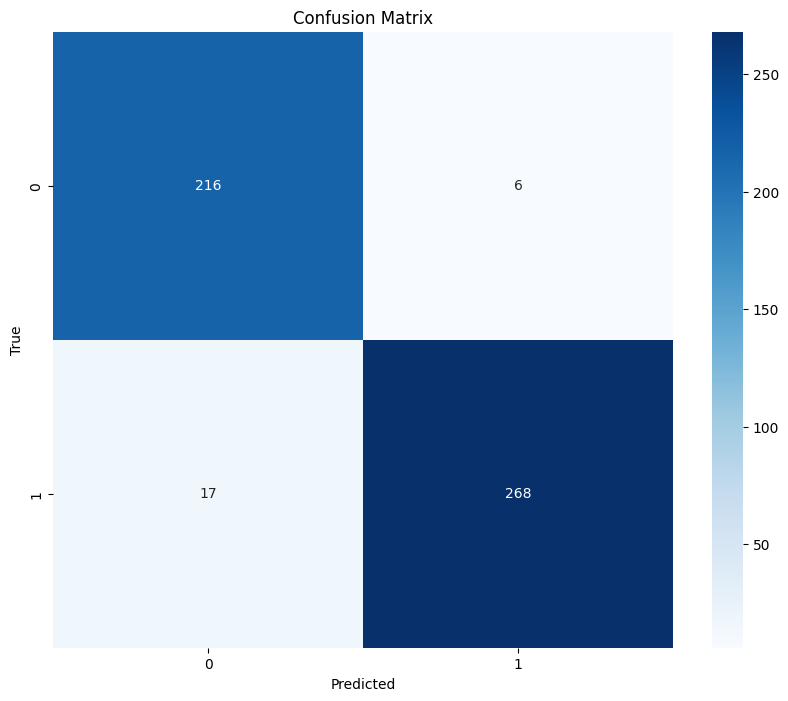

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [51]:
trainer.save_model("./final_model")